In [24]:
import os

# Data management
import pandas as pd

# Data preprocessing and trasformation (ETL)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Math and Stat modules
import numpy as np
from scipy.special import logit, expit
from scipy import stats

#Supervised Learning

# Unsupervised Learning

# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


# From getting to pre-processing data
In questa notebook affronteremo alcuni elementi che fanno parte di un progetto orientato al Machine Learning:
1. Ottenere i dati (facilitato)
2. Visualizzare i dati ottenuti
3. Trasformare/ manipolare i dati per fornire un input agli algoritmi di ML

A fine didattici/progetti personali, le fonti per ottenere dataset open sono molteplici:
- Kaggle (https://www.kaggle.com/)
- Machine Learning repository @ UC Irvine (https://archive.ics.uci.edu/ml/index.php)
- Reddit: subreddit dataset (https://www.reddit.com/r/datasets/)

Per questa prima esperienza utilizziamo un dataset ottenuto da Kaggle che affronta il problema dall **churn prediction**. Possiamo sintetizzare il problema in questo modo: *dato un insieme di clienti che hanno sottoscritto un servizio e caratterizzati/descritti da un insieme di proprieta', identificare un sottoinsieme di client che molto probabilmente abbondonera' in un dato momento nel futuro (di solito a breve termine) il servizio*. Il problema e' piuttosto generico in quanto riguarda in sostanza la risoluzione di un contratto.

<p style="border: 3px solid crimson;box-shadow: 5px 6px indianRed;padding:20px;">Formalmente ogni cliente $c$ e' descritto da un vettore $\mathbf{c}=<c_1,\ldots,c_n>$ t.c. $c_i\in S_i$, dove $S_i$ e' un insieme, denota la proprieta' $i$-esima che caratterizza l'utente $c$. Per predirre qualora un generico utente con determinate proprieta' al tempo $t$, al tempo $t+\Delta t$ abbandoni il servizio, possiamo **imparare** (learning) in modo automatico (machine) una funzione $f:S_1\times\ldots\times S_n\rightarrow \{0,1\}$, dove $0$ indica la permanenza nel servizio, viceversa $1$ indica l'abbandono del servizio.</p>

Nel nostro caso affrontiamo il problema di churn prediction in ambito bancario: credit card churn prediction. 

Il dataset e' disponibile all'indirizzo https://www.kaggle.com/sakshigoyal7/credit-card-customers e riporta la seguente descrizione:
```
A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction.
This dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features.
We have only 16.07% of customers who have churned. Thus, it's a bit difficult to train our model to predict churning customers.
```

### Definire l'obiettivo
Lo sviluppo di un progetto che utilizzi ML solitamente e' orientato ad un **obiettivo** che non riguarda propriamente il ML, ma che utilizza le metodologie ML per **raggiungere** un'obiettivo. L'obiettivo determina:
- come modello il problema
    - supervisionato/non supervisionato, classificazione/regressione, batch/online, univariata/multivariata
- quali modelli/algoritmi adottare
    - fortemente dipendente dal punto precedente
- quali misure di performance utilizzare nella valutazione del modello

Nel nostro caso (credi card churn prediction) l'obiettivo e'molto specifico e ben definito, e la precedente trattazione ci porta a modellare il problema come un problema _supervisionato_ di _classificazione_ binaria in modalita' batch dato che il dataset e' facilmente caricabile in memoria.

## Getting and loading the data

Per un'analisi preliminare del dataset e caricarlo in memoria utilizziamo il modulo **pandas**

In [4]:
raw_dataset = pd.read_csv('BankChurners.csv')

_Commento_: Potevo avere un'anteprima del file utilizzando anche un foglio di calcolo, dato che il formato e' CSV. E' utile verificare se la prima riga del file sia l'intestazione o header, e quindi contenere il nome delle colonne. Per verificare la presenza dello header posso utilizzare il comando _head_ della shell.

Per avere una prima intuizione sul tipo di dati messi a disposizione, possiamo visualizzare le prime 5 righe del dataset utilizzando il metodo **head**

In [5]:
raw_dataset.head()

CLIENTNUM  ... Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0  768805383  ...                                            0.99991                                                                                
1  818770008  ...                                            0.99994                                                                                
2  713982108  ...                                            0.99998                                                                                
3  769911858  ...                                            0.99987                                                                                
4  709106358  ...                                            0.99998                                                                                

[5 rows x 23 columns]

Ci sono 23 colonne.

Per avere una piu'completa descrizione della struttura del dataset utilizziamo i metodi **info** oppure **describe**. Il primo metodo e' piu'orientato alla rappresentazione del dato, mentre il secondo metodo riporta le statistiche riguardanti le varie colonne, qualora siano di tipo numerico.

In [6]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

Confermiamo che abbiamo dati riguardanti 10127 clienti e in questo caso non abbiamo dati mancanti (Non-null count). I tipi di dati sono sia numerici sia categorici (Dtype).

**NB**: A seguire il dataset originale viene corrotto inserendo dati mancanti. Il dataset corrotto e' contenuto nel file _BankChurnersMissingData.csv_.

In [7]:
raw_dataset.describe()

CLIENTNUM  ...  Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count  1.012700e+04  ...                                       10127.000000                                                                                 
mean   7.391776e+08  ...                                           0.840003                                                                                 
std    3.690378e+07  ...                                           0.365301                                                                                 
min    7.080821e+08  ...                                           0.000420                                                                                 
25%    7.130368e+08  ...                                           0.999660                                                                                 
50%    7.179264e+08  ...                                           0.999820                                                                                 
75%    7.731435e+08  ...                                           0.999900                                                                                 
max    8.283431e+08  ...                                           0.999990                                                                                 

[8 rows x 17 columns]

Per avere anche una prima impressione sulle colonne di tipo categorico/testuale possiamo utilizzare il metodo **value_counts**.

🤡 Su diverse microblogging platforms trovare numerosi thread sulla controintuivita' del nome di questo metodo. SPOILER: la probabilita' di scriverlo correttamente al primo colpo e' prossima allo zero 🤡.

In [8]:
raw_dataset['Gender'].value_counts()

F    5358
M    4769
Name: Gender, dtype: int64

Infine otteniamo il nome delle varie colonne in modo da inferire - qualora non sia specificato in qualche documento - il significato della colonna.<br>
Tramite l'attributo **columns** otteniamo questa informazione

In [ ]:
raw_dataset.columns

| Nome colonna | Significato|
| --- | --- |
|CLIENTNUM| ID del cliente|
|Attrition_Flag| Indica se il cliente ha abbandonato (valore 1)|
|Customer_Age| Eta' del cliente in anni|
|Gender|Genere del cliente|
|Dependent_count| Numero di dipendenti|
|Education_Level| Livello di istruzione del cliente|
|Marital_Status| Stato civile|
|Income_Category| Livello di reddito in dollari|
|Card_Category| Tipo di carta di credito|
|Months_on_book| Numero di mesi di iscrizione al servizio|
|Total_Relationship_Count| Numero di prodotti in possesso del cliente|
|Months_Inactive_12_mon| Numero di mesi di inattivita' negli ultimi 12 mesi|
|Contacts_Count_12_mon| Numero di contatti negli ultimi 12 mesi|
|Credit_Limit| Limite di credito sulla carta|
|Total_Revolving_Bal| Bilancio revolving|
|Avg_Open_To_Buy|
|Total_Amt_Chng_Q4_Q1| Differenza del totale delle transazioni tra Q4 e Q1|
|Total_Trans_Amt| Totale delle transazioni su ultimi 12 mesi|
|Total_Trans_Ct| Numero di transazioni negli ultimi 12 mesi|
|Total_Ct_Chng_Q4_Q1| Differenza del numero di transazioni in Q4 rispetto a Q1|
|Avg_Utilization_Ratio| ?|
|Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1| Da eliminare|
|Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2| Da eliminare|

Un'analisi preliminare delle caratteristiche del dataset puo' avvenire in modo _qualitativo_ attraverso la **visualizzazione** della **distribuzione delle proprieta'**. 

Utilizziamo il modulo **matplotlib** per la visualizzazione nel corso di questo laboratorio, insieme al modulo **seaborn**.

In pandas il metodo **hist** permette una rapida visualizzazione della distribuzione delle proprieta' numeriche attraverso istogrammi.

In [9]:
# Prima di visualizzare le distribuzioni, rimuoviamo le colonne che iniziano con Naive Bayes e la colonna con il codice cliente
raw_dataset.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                  'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
                  'CLIENTNUM'],
                 axis=1,
                 inplace=True)

array([[<AxesSubplot:title={'center':'Customer_Age'}>,
        <AxesSubplot:title={'center':'Dependent_count'}>,
        <AxesSubplot:title={'center':'Months_on_book'}>,
        <AxesSubplot:title={'center':'Total_Relationship_Count'}>],
       [<AxesSubplot:title={'center':'Months_Inactive_12_mon'}>,
        <AxesSubplot:title={'center':'Contacts_Count_12_mon'}>,
        <AxesSubplot:title={'center':'Credit_Limit'}>,
        <AxesSubplot:title={'center':'Total_Revolving_Bal'}>],
       [<AxesSubplot:title={'center':'Avg_Open_To_Buy'}>,
        <AxesSubplot:title={'center':'Total_Amt_Chng_Q4_Q1'}>,
        <AxesSubplot:title={'center':'Total_Trans_Amt'}>,
        <AxesSubplot:title={'center':'Total_Trans_Ct'}>],
       [<AxesSubplot:title={'center':'Total_Ct_Chng_Q4_Q1'}>,
        <AxesSubplot:title={'center':'Avg_Utilization_Ratio'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

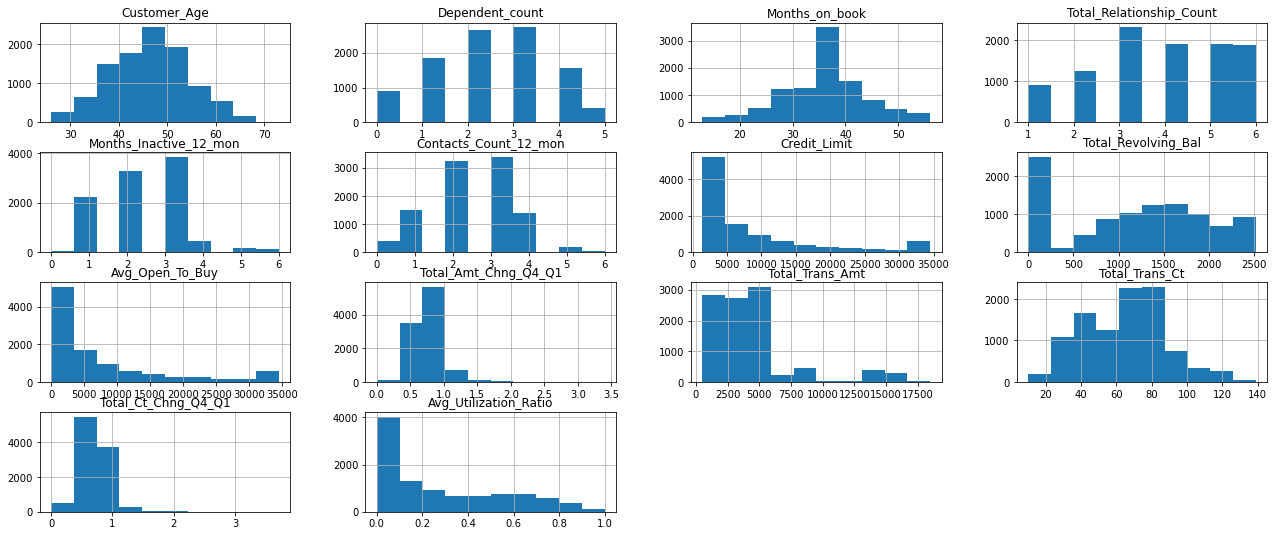

In [10]:
raw_dataset.hist(figsize=(22,9))

Dal momento che il dataset non e' troppo grande, possiamo valutare il coefficiente di correlazione di Pearson mediante il metodo **corr**.

In [9]:
matrice_correlazione = raw_dataset.corr()

In [10]:
matrice_correlazione['Customer_Age'].sort_values(ascending=False)

Customer_Age                1.000000
Months_on_book              0.788912
Months_Inactive_12_mon      0.054361
Total_Revolving_Bal         0.014780
Avg_Utilization_Ratio       0.007114
Credit_Limit                0.002476
Avg_Open_To_Buy             0.001151
Total_Relationship_Count   -0.010931
Total_Ct_Chng_Q4_Q1        -0.012143
Contacts_Count_12_mon      -0.018452
Total_Trans_Amt            -0.046446
Total_Amt_Chng_Q4_Q1       -0.062042
Total_Trans_Ct             -0.067097
Dependent_count            -0.122254
Name: Customer_Age, dtype: float64

Modificando il parametro _method_ posso cambiare il tipo di correlazione, verificando l'esistenza di una correlazione monotonica, non necessariamente lineare tra le proprieta'. Nel caso in analisi utilizziamo il coefficiente di rank correlation di Spearman (Kendall rank correlation e' altra opzione).

In [11]:
matrice_ranking_correlazione = raw_dataset.corr(method='spearman')

In [12]:
matrice_ranking_correlazione['Customer_Age'].sort_values(ascending=False)

Customer_Age                1.000000
Months_on_book              0.768901
Months_Inactive_12_mon      0.044389
Total_Revolving_Bal         0.013551
Avg_Utilization_Ratio       0.010562
Credit_Limit                0.002435
Avg_Open_To_Buy            -0.002146
Contacts_Count_12_mon      -0.014399
Total_Relationship_Count   -0.014495
Total_Trans_Amt            -0.038726
Total_Ct_Chng_Q4_Q1        -0.040285
Total_Trans_Ct             -0.053851
Total_Amt_Chng_Q4_Q1       -0.070538
Dependent_count            -0.143583
Name: Customer_Age, dtype: float64

Ma il risultato non cambia :-)

### Visualizing the "correlation"
Un'analisi qualitativa della correlazione e' effettuabile attraverso la visualizzazione delle **distribuzioni congiunte** - a coppie - delle proprieta' di tipo numerico.

Scegliamo un sottoinsieme di caratteristiche che hanno un diverso livello di correlazione con l'eta' del cliente e visualizziamo una grigia che contiene gli scatter plot di coppie di proprieta'

In [14]:
colonne_interesse = ['Customer_Age', 'Months_on_book', 'Credit_Limit', 'Total_Trans_Amt']

array([[<AxesSubplot:xlabel='Customer_Age', ylabel='Customer_Age'>,
        <AxesSubplot:xlabel='Months_on_book', ylabel='Customer_Age'>,
        <AxesSubplot:xlabel='Credit_Limit', ylabel='Customer_Age'>,
        <AxesSubplot:xlabel='Total_Trans_Amt', ylabel='Customer_Age'>],
       [<AxesSubplot:xlabel='Customer_Age', ylabel='Months_on_book'>,
        <AxesSubplot:xlabel='Months_on_book', ylabel='Months_on_book'>,
        <AxesSubplot:xlabel='Credit_Limit', ylabel='Months_on_book'>,
        <AxesSubplot:xlabel='Total_Trans_Amt', ylabel='Months_on_book'>],
       [<AxesSubplot:xlabel='Customer_Age', ylabel='Credit_Limit'>,
        <AxesSubplot:xlabel='Months_on_book', ylabel='Credit_Limit'>,
        <AxesSubplot:xlabel='Credit_Limit', ylabel='Credit_Limit'>,
        <AxesSubplot:xlabel='Total_Trans_Amt', ylabel='Credit_Limit'>],
       [<AxesSubplot:xlabel='Customer_Age', ylabel='Total_Trans_Amt'>,
        <AxesSubplot:xlabel='Months_on_book', ylabel='Total_Trans_Amt'>,
        <AxesS

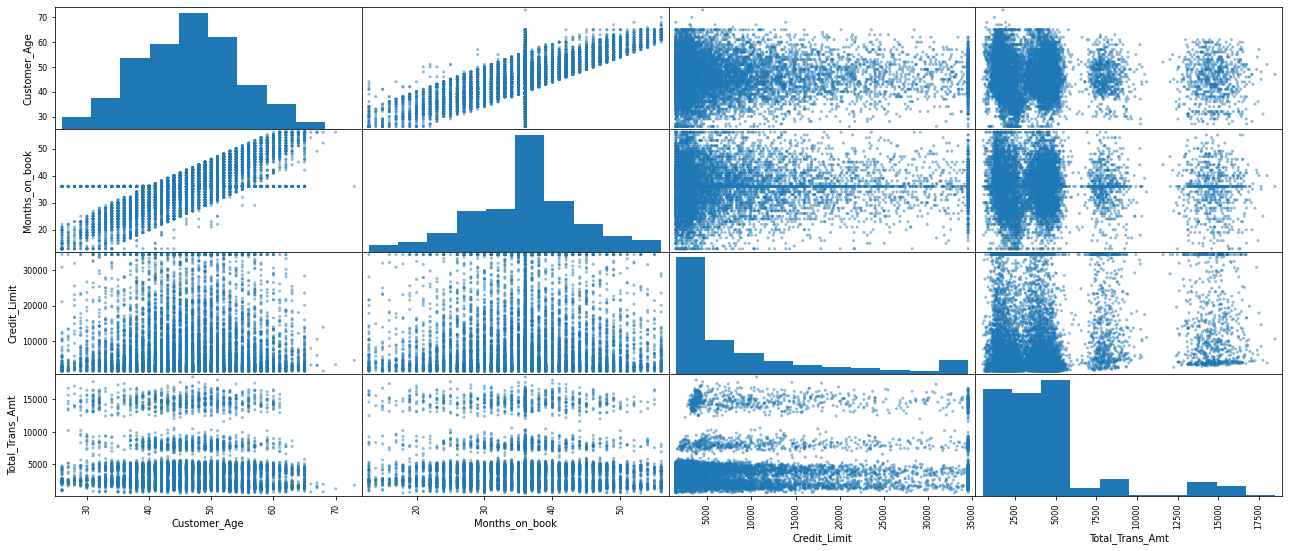

In [15]:
scatter_matrix(raw_dataset[colonne_interesse], figsize=(22,9))

Per aumentare la leggibilita' e' possibile specificare la coppia di proprieta' di cui analizzare la distribuzione congiunta.

<AxesSubplot:xlabel='Customer_Age', ylabel='Total_Trans_Ct'>

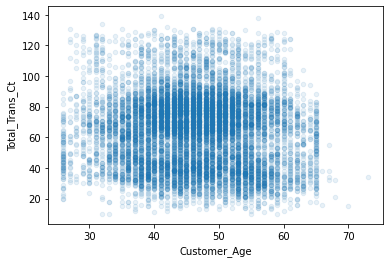

In [16]:
raw_dataset.plot(kind='scatter', x = 'Customer_Age', y='Total_Trans_Ct', alpha=0.1)

<AxesSubplot:xlabel='Customer_Age', ylabel='Months_on_book'>

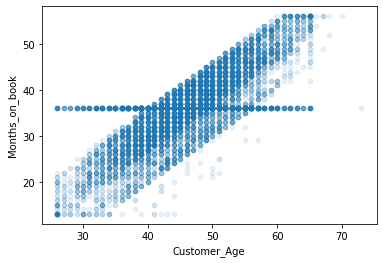

In [17]:
raw_dataset.plot(kind='scatter', x = 'Customer_Age', y='Months_on_book', alpha=0.1)

In questa fase di esplorazionee, posso definire delle proprieta' che **combinano** le proprieta' iniziali.

Per esempio definiamo l'ammontare medio di una transazione negli ultimi ultimi 12 mesi.

In [18]:
raw_dataset['Avg_transaction'] = raw_dataset['Total_Trans_Amt']/raw_dataset['Total_Trans_Ct']

.. e ne visualizziamo la distribuzione.

<AxesSubplot:>

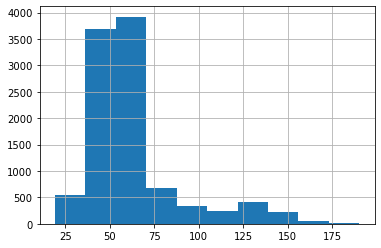

In [19]:
raw_dataset['Avg_transaction'].hist()

# Preparing the data for Machine Learning algorithms
In questa sezione prepariamo il nostro dataset per essere utilizzato da un modello di ML - nel nostro caso un classificatore binario.

**NB**: Prima di procedere, dobbiamo caricare un versione modificata del dataset orginale in cui sono state cancellate delle entry relative ad alcuni clienti e alcune collane. Tale modifica e' stata resa necessaria per introdurre alcuni step di data cleaning/data preparation, che altrimenti non si sarebbero potuti applicare.

Carichiamo la nuova versione del dataset ed analizziamo quali feature sono state corrotte e/o contenenti dati mancanti.

In [3]:
credit_data = pd.read_csv('BankChurnersMissingData.csv')

In [21]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10121 non-null  float64
 3   Gender                                                                           

Le colonne 22 e 23 contengono molte entry con dati mancanti, mentre abbiamo dati mancanti sporadici nelle colonne Customer_Age, Months_Inactive_12_mon, Total_Revolving_Bal.

Molti algoritmi di ML non gestiscono i **dati mancanti**, di conseguenza una fase della preparazione dei dati e' la definizione di funzioni che gestiscono i dati mancanti. Le opzioni piu' utilizzate sono 3:
- rimuovo il sample che contiene le entry corrotte/mancanti => cancellazione della riga
- rimuovo l'intera feature/colonna contenente i dati mancanti/corrotti => rimozione della colonna
- imputo/inferisco i dati mancanti/corrotti mediante diverse strategie ben consolidate oppure originali

Prima di gestire i dati mancanti, vediamo come **identificare** alcuni sample che contengono un dato mancante.

In [22]:
sample_missing_credit = credit_data[credit_data['Customer_Age'].isnull()]
sample_missing_credit

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
101  713843283  Existing Customer           NaN      F                3   
173  712608783  Existing Customer           NaN      M                2   
306  710572458  Existing Customer           NaN      F                3   
428  713134458  Existing Customer           NaN      M                3   
518  721232058  Existing Customer           NaN      M                1   
628  780481308  Existing Customer           NaN      F                3   

    Education_Level Marital_Status Income_Category Card_Category  \
101         Unknown        Married         Unknown        Silver   
173     High School        Married    $80K - $120K        Silver   
306     High School        Married         Unknown          Blue   
428     High School        Married         $120K +          Blue   
518        Graduate        Unknown     $40K - $60K        Silver   
628        Graduate        Married         Unknown          Blue   

     Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
101              34  ...       34516.0               2053.0          32463.0   
173              45  ...       34516.0               1260.0          33256.0   
306              24  ...       15439.0                  0.0          15439.0   
428              43  ...       13219.0                  0.0          13219.0   
518              41  ...       20231.0                977.0          19254.0   
628              24  ...       10584.0               1550.0           9034.0   

     Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
101                 1.034             1487              26   
173                 0.588             1504              34   
306                 0.742             2069              43   
428                 0.576             1097              24   
518                 0.893             1215              36   
628                 0.692             1567              33   

     Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  \
101                0.733                  0.059   
173                0.789                  0.037   
306                0.536                  0.000   
428                0.500                  0.000   
518                0.714                  0.048   
628                0.320                  0.146   

     Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
101                                                NaN                                                                                    
173                                                NaN                                                                                    
306                                                NaN                                                                                    
428                                                NaN                                                                                    
518                                           0.000079                                                                                    
628                                           0.000118                                                                                    

     Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
101                                                NaN                                                                                   
173                                                NaN                                                                                   
306                                                NaN                                                                                   
428                                                NaN                                                                    

## Eliminating samples with missing values
Andiamo ad eliminare la riga relativa al cliente con un valore mancante nella colonna 'Total Revolving_Bal'. In questo caso non eseguiamo nessuna imputazione dal momento che togliamo un solo campione/sample.

In [4]:
credit_data.dropna(subset=['Total_Revolving_Bal'],
                   inplace=True
                  )

In [24]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10126 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10126 non-null  int64  
 1   Attrition_Flag                                                                                                                      10126 non-null  object 
 2   Customer_Age                                                                                                                        10120 non-null  float64
 3   Gender                                                                           

Ho eliminato solo una riga.

## Eliminating features with missing values
Il dataset contiene due colonne che:
1) contengono molti dati mancanti
2) sono inutili al fine della classificazione in quanto contengono la predizione di un classificatore

In questo caso possiamo tranquillamente eliminare le colonne. In generale, tutttavia, l'eliminazione di una feature deve seguire da una scelta ponderata sulle rimanenti opzioni per la gestione dei dati mancanti.

In [5]:
credit_data.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
                   inplace=True,
                   axis=1
                  )

In [26]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10126 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10126 non-null  int64  
 1   Attrition_Flag            10126 non-null  object 
 2   Customer_Age              10120 non-null  float64
 3   Gender                    10126 non-null  object 
 4   Dependent_count           10126 non-null  int64  
 5   Education_Level           10126 non-null  object 
 6   Marital_Status            10126 non-null  object 
 7   Income_Category           10126 non-null  object 
 8   Card_Category             10126 non-null  object 
 9   Months_on_book            10126 non-null  int64  
 10  Total_Relationship_Count  10126 non-null  int64  
 11  Months_Inactive_12_mon    10125 non-null  float64
 12  Contacts_Count_12_mon     10126 non-null  int64  
 13  Credit_Limit              10126 non-null  float64
 14  Total_

## Imputing missing values
Abbiamo ancora una colonna che contiene 6 dati mancanti. In questo caso possiamo inferire il valore dei dati mancanti.

### Imputing missing values in Pandas
Gestiamo l'imputazione del dato mancante in Pandas, mediante alcune statistiche e il metodo **fillna**. Ci concentriamo sulla colonna 'Customer_Age'

In [ ]:
median_age = credit_data['Customer_Age'].median()
median_age
# credit_data['CustomerAge'].fillna(median_age, inplace=1)

### Imputing missing values in Scikit-Learn
Scikit-learn - SKL - offre una soluzione piu' completa per gestire l'imputazione dei dati mancanti.

La classe **SimpleImputer** fornisce una strategia base. I valori mancanti possono essere imputati da valori costanti oppure statistiche puntuali.

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer

In [27]:
from sklearn.impute import SimpleImputer

In [68]:
imputer = SimpleImputer(strategy='median')
imputer.fit(credit_data['Customer_Age'].values.reshape(-1, 1))
imputer.statistics_

array([46.])

Il metodo fit non esegue alcuna sostituzione ma esegue solamente la strategia utilizzata sul vettore o matrice che ricve in input.

In [69]:
credit_data['Customer_Age'] = imputer.transform(credit_data['Customer_Age'].values.reshape(-1, 1))

Il metodo transform applica la strategia al vettore/matrice

In [ ]:
credit_data.info()

Scikit-Learn API e' organizzato secondo una serie di principi che ne ispirano il design e l'architettura:

1) **Consistency**: ogni oggetto condivide un'interfaccia consistente e condivisa
    - **Estimator**: un qualsiasi oggetto che stima alcuni parametri. La stima e' eseguita dal metodo **fit** che richiede un dataset come parametro.
    - **Transformers**: un estimator che trasforma un dataset. La trasformazione e' eseguita dal metodo **transform** che richiede il dataset da trasformare come parametro. Restituisce il dataset trasformato. Esiste un metodo **fit_trasform** che esegue entrambi i metodi ed e'ottimizzato.
    - **Predictors**: un oggetto estimator che predice. Un predictor ha il metodo **predict** che richiede un insieme di sample nuovi e restituisce le predizioni associate.
2) **Inspection**: tutti gli iperparametri sono accessibili mediante attributi, cosi' come i parametri appresi. Si utilizza la notazione con underscore (vedi statistics_ in SimpleImputer)
3) **Nonproliferation of classes**: datasets sono Numpy arrays o matrici sparse Scipy. Non ci sono oggetti dataset definiti da utenti
4) **Composition**: i moduli/classi rilasciati sono componibili
5) **Sensible defaults**: si devono definire dei valori di default ragionevoli

Abbiamo un ulteriore problema costituito dalla colonna 'Income_Category'.

In [ ]:
credit_data['Income_Category'].value_counts()

Una possibile soluzione e' quella di inferire i valori mancanti sulla base delle feature. In questo caso dobbiamo risolvere un problema di classificazione/regressione utilizzando le entry con i valori non mancanti come label. SKL mettere a disposizione la classe sperimentale **IterativeImputer** (https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer), tuttavia non e' possibile utilizzarlo con in valori categorici che abbiamo. Infatti, se eseguite le due celle seguenti ottenete un errore. 

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
imputer_it = IterativeImputer(max_iter=10, random_state=0)
imputer_it.fit(credit_data[['Gender','Income_Category']].values)
IterativeImputer(random_state=0)
y = credit_data[['Gender','Income_Category']].values
imputer_it.transform(y)

In questo caso applichiamo una soluzione piu' 'naive' in cui i valori unknown vengono sostituiti in modo casuale, rispettando la distribuzione dei rimanenti livelli di reddito.

In [ ]:
count_ic = credit_data[credit_data['Income_Category'] != 'Unknown']['Income_Category'].value_counts()
v, f = count_ic.index, count_ic.values/count_ic.sum()
credit_data.loc[credit_data['Income_Category'] == 'Unknown','Income_Category'] = np.random.choice(v,size=1112,p=f)

In [ ]:
credit_data['Income_Category'].value_counts()

## Handling categorical data
Per ora abbiamo trattato principalmente dati numerici. Tuttavia, dal momento che molti algoritmi di apprendimento non trattano dati categori o testuali, dobbiamo codificare i dati categorici in dati numerici.

Un primo approccio per convertire un dato categorico in un dato categorico in un dato numerico e'utilizzare la classe **OrdinalEncoder**, la quale assegna ad ogni categoria un valore numerico distinto.

Applichiamo la classe alla colonna 'Card_Category'

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
ord_enc = OrdinalEncoder()
credit_data['Card_Category'] = ord_enc.fit_transform(credit_data['Card_Category'].values.reshape(-1, 1))

Le categorie identificate sono associate all'attributo **categories_**

In [ ]:
ord_enc.categories_

In [ ]:
credit_data.info()

Un problema di questo tipo di trasformazione e' l'introduzione di un ordinamento non presente - caso precedente, o il cambiamento dell'ordinamento. 

Trattiamo il secondo caso, trasformando la colonna categorica'Income_Category'. Nonostante sia una feature categorica, le fasce di reddito sono crescenti quindi esiste un ordinamento. Per rispettare questo ordinamento utilizziamo sempre la classe OrdinalEncoder, ma definiamo a priori la lista ordinata delle categorie.

In [ ]:
rank_cat = [['Less than $40K','$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']]
ord_enc_income = OrdinalEncoder(categories=rank_cat)
credit_data['Income_Category_Num'] = ord_enc_income.fit_transform(credit_data['Income_Category'].values.reshape(-1, 1))

In [ ]:
credit_data[['Income_Category_Num','Income_Category']]

Per evitare l'introduzione di un ordimento fittizio, si crea una feature binaria per ogni categoria. Per ogni sample, viene posta a 1 la feature/colonna che corrisponde alla categoria originaria. Questo tipo di codifica viene detta **one-hot encoding** ed implementata dalla classe **OneHotEncoder** (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) 

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
edu_enc = OneHotEncoder()
edu_ohe = edu_enc.fit_transform(credit_data['Education_Level'].values.reshape(-1,1))

In [7]:
credit_data['Education_Level'].unique()

array(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
       'Post-Graduate', 'Doctorate'], dtype=object)

In [33]:
edu_ohe

<10126x7 sparse matrix of type '<class 'numpy.float64'>'
	with 10126 stored elements in Compressed Sparse Row format>

In [35]:
edu_ohe.toarray().shape

(10126, 7)

Se un attributo di tipo categorico assume valori su un ampio insieme di opzioni, la codifica one-hot encoding restituisce un elevato numero di colonne/dummy features che possono avere un certo impatto sulle performance dell'algoritmo di apprendimento. In questo caso posso a) rappresentare le feature categorico in modo numerico utilizzando un mapping piu' avanzato rispetto alla codifica one-hot; 2) posso ridurre la dimensionalita' della codifica utilizzando/apprendendo un embedding in una spazio a dimensione ridotta rispetto al numero/dimensione della feature categorica.

### Custom Transformer
E' possibile definire nuovi transfomer in caso ci sia la necessita' di operazioni di data cleaning o combinazione specifiche per il contesto in cui si opera.

Al fine di utilizzare il nuovo transformer in una pipeline e dal momento che SKL si basa sul duck typing - "If it walks like a duck and it quacks like a duck, then it must be a duck" - devo creare una classe che implementi 3 metodi:
- fit
- transform
- fit_transform

Il terzo metodo non lo devo implementare se estendo la classe **TransformerMixin** + se eredito anche dalla classe **BaseEstimator** ottengo anche i metodi **get_params** and **set_params** - utili per il tuning degli iperparametri.

Nel nostro esempio proviamo a scrivere un Imputer specifico per la gestione della feature 'Income_Category'

In [59]:
class UnknownImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, nan_value, strategy = 'proportional'):
        self.strategy = strategy
        self.nan_value = nan_value
        
    def fit(self, X, y=None):
        unique_values, count = np.unique(X,return_counts=True)
        self.num_nan = count[unique_values == self.nan_value]
        self.count = count[unique_values != self.nan_value]
        self.unique_values = unique_values[unique_values != self.nan_value]
        return self
    
    def transform(self, X):
        X_new = X.copy()
        if self.strategy == 'proportional':
            freq = self.count / np.sum(self.count)
            X_new[X_new == self.nan_value] = np.random.choice(self.unique_values,
                             size=self.num_nan,
                             p=freq)
        if self.strategy == 'uniform':
            X_new[X_new == self.nan_value] = np.random.choice(self.unique_values,
                                                              size=self.num_nan
                                                             )
        return X_new

In questo caso, il transformer ha un iperparametro _strategy_ che puo' essere utilizzato per verificare se la strategia di imputazione influenza le performance degli algoritmi di ML che utilizzeremo in seguito.

### Feature Scaling
Una delle trasnformazioni che usualmente si applicano e' la **feature scaling**. Il motivo e' legato alle difficolta' di alcuni algortimi di apprendimento nel gestire dati con ordini di grandezza variabili. Per esempio la distanza euclidea tra due vettori, in cui una dimensione ha ordine di grandezza superiori alla seconda, sara' dominata dalla dimensione con ordine di grandezza superiore.

In [62]:
a, b  = np.array([6, 2500000]) , np.array([14, 2506500])
np.linalg.norm(a-b)

6500.004923075058

Un metodo utilizzato per il feature scaling, e' la **standardization**:
$$z_i^k=\frac{x_i^k-\mu_k}{\sigma_k}$$
dove $\mu_k$ e $\sigma_k$ indicano la media e la deviazione standard della feature $k$. La maggior parte dei valori standardizzati appartengono all'intervallo $[-3,3]$, anche se la definizione non mette dei limiti al range di variazione.

In SKL il trasformer utilzzato per applicare la standardizzazione e' **StandardScaler**.

Per esempio, possiamo applicare la standardizzazione alla colonna 'Age'.

In [71]:
std_scaler = StandardScaler()
age_scaled = std_scaler.fit_transform(credit_data['Customer_Age'].values.reshape(-1,1))

In [73]:
min(age_scaled), max(age_scaled)

(array([-2.53615262]), array([3.32790558]))

Un metodo alternativo e' riportare i valori di una feature in un intervallo limitato, i.e. con un minimo e un massimo:
$$s_i^k=\frac{x_i^k-min_k}{max_k - min_k}$$
dove $min_k$ e $max_k$ indicano rispettivamente il valore minimo e massimo assunti dalla feature $k$. Il vantaggio della normalizzazione e' preservare la sparsita' dei dati. Lo svantaggio e' l'influenza di outlier che aumentano il range tra valore massimo e minimo, tendendo a concentrare la distribuzione dei dati in un sottointervallo di $[0,1]%=$.

In SKL la normalizzazione e' implementata dalle classi **MinMaxScaler** e **MaxAbsScaler**. La prima classe normalizza nell'intervallo $[0,1]$, mentre la seconda nell'intervallo $[-1,1]$. La seconda classi si usa con dati gia' centrati rispetto allo zero o dati sparsi.

In [74]:
minmax_scaler = MinMaxScaler()
age_minmax = minmax_scaler.fit_transform(credit_data['Customer_Age'].values.reshape(-1,1,))

Se i dati contengono molti outliers oppure la distribuzione e' heavy-tail, uso della standardizzazione puo' non funzionare. In questo caso, la classe **RobustScaler** e' utile in quanto scala la feature utilizzando statistiche robuste agli outlier, i.e. IQR - inter-quantile range e mediana.

In [ ]:
robust_scaler = RobustScaler()
limit_scaled =robust_scaler.fit_transform(credit_data['Credit_Limit'])

### Discretization
Mediante discretizzazione riporto una feature continua in un insieme discreto di valori. La discretizzazione avviene attraverso:
1) discretizzazione in k bin
2) binarizzazione

Il primo metodo e' implementato dalla classe **KBinsDiscretizer**. Il dataset trasforma di defult viene restituito nella codifica one-hot, tuttavia e' possibile cambiare il tipo di codifica, per esempio 'ordinale'. Vengono implementate strategie di binning differenti, selezionabili tramite il parametro _strategy_. Infine posso utilizzare dei bin personalizzati tramite la classe **FunctionTransfomer**. 

In [79]:
bins = [0,18,65,np.inf]
labels = ['Giovane', 'Adulto', 'Anziano']
age_discretizer = FunctionTransformer(pd.cut,
                                     kw_args = {'bins':bins,'labels':labels,'retbins':False})
age_discretizer.fit_transform(credit_data['Customer_Age'].values)

['Adulto', 'Adulto', 'Adulto', 'Adulto', 'Adulto', ..., 'Adulto', 'Adulto', 'Adulto', 'Adulto', 'Adulto']
Length: 10126
Categories (3, object): ['Giovane' < 'Adulto' < 'Anziano']

Il secondo metodo - binarizzazione - trasforma il valore numerico in un valore booleano secondo una soglia. La classe che implementa la binarizzazione e' **Binarizer**

In [82]:
age_binarizer = Binarizer(threshold=18)
age_binarizer.fit_transform(credit_data['Customer_Age'].values.reshape(-1,1))

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

Ulteriori approfondimenti sul feature scaling in SKL sono disponibili:
- https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
- https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

## Transformation Pipeline
La preparazione del dataset per l'utilizzo di un successvio algorimtmo di apprendimento richiede una serie trasformazioni da eseguire nell'rodine corretto.<br>
Per facilitare ed organizzare programmaticamente il processo di data preparation, SKL fornisce la classe **Pipeline**.

Il costruttore della classe richiede una _lista_ di tuple/coppie (string, oggetto Estimator) che definisco una sequenza di processamento del dataset. Tutti gli oggetti Estimator tranne l'ultimo devono essere Transfomer (metodo fit_transform). Le stringhe definisco dei nomi da assegnare ad ogni step della pipeline e saranno utili nella fase di ottimizzazione degli iperparametri. L'oggetto Pipeline espone i metodi dell'ultima Estimator presente nella lista utilizzata al momento dell'inizializzazione. Il metodo _fit_ della pipeline invoca i metodi *fit_transform* di ogni oggetto Estimator in modo sequenziale, secondo quanto specificato dalla lista.

Prima di definire l'intero Pipeline per il preprocessing del dataset, introduciamo la classe **ColumnTransformer** per applicare le trasformazioni specifiche per ogni colonna o sottoinsieme di colonne.

A titolo di esempio, decidiamo di applicare una standardizzazione alle colonne di tipo numerico e one-hot encoding alle colonne di tipo categorico.

In [86]:
numeric_features = credit_data.select_dtypes(include=['int64','float64']).columns
numeric_features

Index(['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [89]:
cat_features = credit_data.select_dtypes(exclude=['int64','float64']).columns
cat_features

Index(['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category'],
      dtype='object')

In [91]:
test_pipeline = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_features),
    ('category', OneHotEncoder(), cat_features)
])

In [93]:
trasformed_credit = test_pipeline.fit_transform(credit_data)

In [95]:
trasformed_credit.shape

(10126, 40)

Il costruttore di ColumnTrasformer richiede una lista di tuple di 3 elementi:
1) Identificativo - string
2) Transformer
3) Lista di colonne (nome /o indice) a cui applicare il transformer

## Pre-processing completo del dataset

In [8]:
credit_card_data = pd.read_csv('BankChurnersMissingData.csv')
credit_card_data.dropna(subset=['Total_Revolving_Bal','Months_Inactive_12_mon'],
                   inplace=True
                  )

# Estraggo la  colonna delle label e la rimuovo dal dataset
credit_card_label = credit_card_data['Attrition_Flag'].map(
    {'Existing Customer':0,
     'Attrited Customer':1
    }
)
credit_card_data.drop(columns=['Attrition_Flag',
                               'CLIENTNUM',
                               'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
                               'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'],
                      inplace=True)

Definiamo un Imputer personalizzato, utilizzando la classe **FunctionTransformer**.

In [10]:
def unknown_imputer(X, missing_value = 'Unknown'):
    X = X.values
    unique_values, count = np.unique(X,return_counts=True)
    num_nan = count[unique_values == missing_value]
    counting = count[unique_values != missing_value]
    values = unique_values[unique_values != missing_value]
    X_new = X.copy()
    freq = counting / np.sum(counting)
    X_new[X_new == missing_value] = np.random.choice(values,size=num_nan,p=freq)
    return X_new

ui = FunctionTransformer(unknown_imputer)

Definisco un insieme di Pipeline per gestire i dati mancanti di Customer_Age e le etichette 'Unknown' che caratterizzano Education_Level, Marital_Status, Income_Category

In [11]:
customer_age_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

category_pipeline = Pipeline([
    ('imputer', FunctionTransformer(unknown_imputer)),
    ('ordinal', OneHotEncoder())
])

Per alcune feature numeriche utilizzo uno scaler RobustScaler, dal momento sembrano di tipo heavy-tail.

In [12]:
features_robust = ['Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy']
features_standard = list(set(credit_card_data.select_dtypes(include=['int64','float64']).columns).difference(set(features_robust + ['Avg_Utilization_Ratio', 'Customer_Age'])))

Infine definisco la mia pipeline di data preparation

In [13]:
data_preprocessing = ColumnTransformer([
    ('age', customer_age_pipeline, ['Customer_Age']),
    ('gender', OrdinalEncoder(categories=[['M','F']]), ['Gender']),
    ('edu', category_pipeline, ['Education_Level']),
    ('status', category_pipeline, ['Marital_Status']),
    ('income', category_pipeline, ['Income_Category']),
    ('card', category_pipeline, ['Card_Category']),
    ('numeric_robust', RobustScaler(), features_robust),
    ('feature_standard', StandardScaler(), features_standard)
],
    remainder = 'passthrough'
)

Calcolo la feature matrix

In [14]:
feature_matrix = data_preprocessing.fit_transform(credit_card_data)

In [15]:
feature_matrix.shape

(10125, 33)

In [18]:
feature_matrix[0,:]

array([-0.16559709,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.95653195, -0.3506676 ,  0.98933552, -0.97406918,  3.83454423,
       -1.32693191,  0.49246419,  0.38454893,  0.76377065,  0.50340881,
        2.62431918, -0.95988128,  0.061     ])

... e per il futuro anche la sequenza delle colonne

In [16]:
columns_name = ['Customer_Age','Gender']
for c in ['Education_Level','Marital_Status','Income_Category']:
    cat_inc_name = [c+'_cat{}'.format(i) for i in range(1,len(credit_card_data[c].unique()))]
    columns_name.extend(cat_inc_name)
columns_name.extend(['Card_Category_cat{}'.format(i) for i in range(1,len(credit_card_data['Card_Category'].unique())+1)])
columns_name.extend(features_robust)
columns_name.extend(features_standard)
columns_name.append('Avg_Utilization_Ratio')
columns_name

['Customer_Age',
 'Gender',
 'Education_Level_cat1',
 'Education_Level_cat2',
 'Education_Level_cat3',
 'Education_Level_cat4',
 'Education_Level_cat5',
 'Education_Level_cat6',
 'Marital_Status_cat1',
 'Marital_Status_cat2',
 'Marital_Status_cat3',
 'Income_Category_cat1',
 'Income_Category_cat2',
 'Income_Category_cat3',
 'Income_Category_cat4',
 'Income_Category_cat5',
 'Card_Category_cat1',
 'Card_Category_cat2',
 'Card_Category_cat3',
 'Card_Category_cat4',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Months_on_book',
 'Total_Relationship_Count',
 'Dependent_count',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Avg_Utilization_Ratio']

# Data Preprocessing with Tensor Flow

Un ulteriore strumento per la trasformazione del dato ci viene fornito da TensorFlow. TF facilita la gestione di dataset di grandi dimensioni e la relativa fase di pre-processing mediante le **Data API** che astraggono tutte le operazioni di basso livello come il multithreading, la gestione delle code di elaborazione e il precaricamento del dato in memoria principale - RAM.

Mediante Data API e' possibile leggere/scrivere file testuali, file binari con dimensione fissa/variabile dei record oppure accedere a database SQL. Oltre alla fase di caricmaneto del dato, Data API permette la gestione e trasformazioni di feature numeriche, categoriche, testuali mediante diverse modalita' di codifica.

In [1]:
import tensorflow as tf

## Data API
Il concetto primario delle Data API e'  il **dataset** = sequenza di elementi dato. All'oggetto dataset e' possibile applicare una serie di trasformazioni come in SKL mediante un insieme di metodi di trasformazioni; ognuno dei quali restituisce un nuovo oggetto dataset.

Nell'esempio creiamo un dataset di 10 elementi, dove ogni elemento e' un tensore 0D, ovvero uno scalare. Da questo dataset, ne creiamo uno nuovo che contiene la ripetizione del primo - 3 volte. Infine, definiamo un nuovo dataset in cui gli elementi vengono raggruppati in gruppi - **batch** - di 7 elementi

In [248]:
dataset = tf.data.Dataset.range(10).repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


La ripetizione del dataset avviene mediante il metodo **repeat**, senza che venga eseguita un'effettiva copia del dataset in memoria principale. Il raggruppamento e' eseguito dal metodo **batch**.

E' possibile applicare una funzione a ciascun elemento del dataset mediante il metodo **map**, eventualmente in modo "parallelo" specificando il parametro *num_parallel_calls*.

Una trasformazione e' applicabile all'interno dataset mediante il metodo **apply**.

Infine mediante il metodo **filter** rimuoviamo gli item che non soddisfano una condizione.

In [249]:
dataset = dataset.map(lambda x: x*2).apply(tf.data.experimental.unbatch()).filter(lambda y: (y % 6) != 0)

In [250]:
for item in dataset:
    print(item)

tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(14, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(14, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(14, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)


### Shuffling data
Abbiamo gia' visto come mescolare il training set rafforzi le assunzioni i.i.d. dei sample del dataset. In TF il metodo piu' semplice per eseguire lo shuffling e' attraverso il metodo **shuffle**. Esso crea un nuovo dataset e inizialmente riempie un buffer con i primi elementi del dataset originale. Quando viene richiesto un elemento, esso viene estratto in modo casuale dal buffer e un nuovo elemento dal dataset originale viene spostato nel buffer. La dimensione del buffer puo' essere specificata.

In [251]:
for i in dataset:
    print(i.numpy(),end=',')

2,4,8,10,14,16,2,4,8,10,14,16,2,4,8,10,14,16,

In [252]:
dataset_shuffled = dataset.shuffle(buffer_size=4, seed=42)
for i in dataset_shuffled:
    print(i.numpy(), end=',')

4,14,8,10,16,2,2,10,8,2,14,4,16,8,10,14,16,4,

Per dataset che non possono caricati completamente in memoria principale, il precedente metodo e' poco efficace. Un'alternativa e' dividere il file del datasets in file di dimensioni ridotte e leggerli simultaneamente interponendo i diversi flussi di lettura.

In [40]:
train_filepaths = ['house_dataset\\train{:02d}.csv'.format(i) for i in range(20)] 
valid_filepaths = ['house_dataset\\validation{:02d}.csv'.format(i) for i in range(10)]
test_filepaths = ['house_dataset\\test{:02d}.csv'.format(i) for i in range(10)]

In [42]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

Di default il precedente metodo restituisce un dataset che mescola i percorsi dei file.

Ora, mediante il metodo **interleave** leggiamo simultaneamente da 5 file reader e impiliamo le linee provenienti dai diversi reader.

In [253]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda fp: tf.data.TextLineDataset(fp).skip(1),
    cycle_length=n_readers
)

Il primo parametro specifica la funzione da applicare ad ogni percorso del file. Per leggere i file in "parallelo" specifico il parametro *num_parallel_calls*. 

In [254]:
for line in dataset.take(5):
    print(line.numpy())

b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598'
b'3.0217,22.0,4.983870967741935,1.1008064516129032,615.0,2.4798387096774195,38.76,-120.6,1.069'
b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782'


Come ultimo passo dobbiamo convertire ogni item - ora e' una stringa binaria - in un tensore

In [255]:
n_inputs = 8

@tf.autograph.experimental.do_not_convert
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return x, y

Il metodo **tf.io.decode_csv** restituisce una lista di 0D Tensor - scalare - i cui valori di default sono specificati dal parametro *record_dafeaults*. Per restituire un tensore 1D trasformiamo la lista in un vettore mediante il metodo **stack**.

In [256]:
preprocess(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 4.5908999e+00,  1.6000000e+01,  5.4758773e+00,  1.0964912e+00,
         1.3570000e+03,  2.9758773e+00,  3.3630001e+01, -1.1771000e+02],
       dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.418], dtype=float32)>)

Riassumendo:

In [56]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat).interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads
    ).shuffle(shuffle_buffer_size).map(preprocess, 
                                       num_parallel_calls=n_parse_threads
                                      ).batch(batch_size)
    return dataset.prefetch(1)

Mediante il metodo **prefecth** indichiamo che durante la fase di training sul batch $n$, venga caricato in memoria il batch $n+1$, in modo da mantenere il carico computazionale attivo e costante, specialmente con architetture CPU + GPU.

![](prefetch.png)

Ora possiamo utilizzare la precedente funzione per creare un oggetto dataset e utilizzare Keras per effettuare il training di un MLP.

In [257]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [67]:
from tensorflow import keras

In [258]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1),
])

In [259]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [260]:
batch_size = 32
history = model.fit(train_set,
          steps_per_epoch=len(X_train) // batch_size,
          epochs=10,
          validation_data=valid_set)

Epoch 1/10
483/483 [==============================] - 1s 1ms/step - loss: 6699284270339450843743387648.0000 - val_loss: 1607327068903562002038784.0000
Epoch 2/10
483/483 [==============================] - 0s 904us/step - loss: 712380253748593512415232.0000 - val_loss: 232384551822015967789056.0000
Epoch 3/10
483/483 [==============================] - 0s 897us/step - loss: 102994702382980113891328.0000 - val_loss: 33597796724305834278912.0000
Epoch 4/10
483/483 [==============================] - 0s 901us/step - loss: 14890797509429889597440.0000 - val_loss: 4857507685738011951104.0000
Epoch 5/10
483/483 [==============================] - 0s 899us/step - loss: 2152884862532007755776.0000 - val_loss: 702288300036155506688.0000
Epoch 6/10
483/483 [==============================] - 0s 898us/step - loss: 311260271718084640768.0000 - val_loss: 101535879010602450944.0000
Epoch 7/10
483/483 [==============================] - 0s 935us/step - loss: 45001489200778838016.0000 - val_loss: 1467989420

In [73]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 808us/step - loss: 14219976704.0000


14219976704.0

In [77]:
model.predict(test_set.map(lambda X, y: X))

array([[-119245.45],
       [-119245.45],
       [-119245.45],
       ...,
       [-119245.45],
       [-119245.45],
       [-119245.45]], dtype=float32)

## TFRecord
TFRecord e' il formato utilizzato da TF per memorizzare e leggere una grande quantita' di dati. E' un formato binario che contiene una **sequenza** di record binari di lunghezza variabile. 

E' possibile creare un TFRecord mediante la classe **TFRecordwriter**.

In [261]:
with tf.io.TFRecordWriter("test.tfrecord") as f:
    f.write(b"Primo record")
    f.write(b"Secondo record")

Mentre posso leggere/caricare un TFRecord mediante la classe **TFRecordDataset**.

In [262]:
percorso = ["test.tfrecord"]
dataset = tf.data.TFRecordDataset(percorso)
for item in dataset:
    print(item.numpy())

b'Primo record'
b'Secondo record'


TFRecordDataset puo' leggere piu' file contemporaneamente specificando il parametro *num_parallel_reads*.

Inoltre, specificando il parametro *compression_type* si puo' comprimere il TFRecord.

In [263]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("test_compresso.tfrecord", options ) as f:
    f.write(b"Primo record")
    f.write(b"Secondo record")

In [264]:
for item in tf.data.TFRecordDataset(["test_compresso.tfrecord"], compression_type="GZIP"):
    print(item)

tf.Tensor(b'Primo record', shape=(), dtype=string)
tf.Tensor(b'Secondo record', shape=(), dtype=string)


TFRecord contengono elementi serializzati di tipo **Protocol Buffer - PB**. PB e' formato binario sviluppato da Google il cui schema e' definibile secondo un linguaggio specifico. Per esempio
```
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}
```
Definisce un PB di tipo Person con un campo stringa di nome 'name' e indice 1, un campo intero id all'indice 2 ed una lista di stringhe il cui nome e' 'email' e il cui indice e' 3. Il valore repeated specifica che il campo email puo' contenere da 0 a molte stringhe.

In TF il PB principale e' **Example** che definisce lo schema di un'istanza che compone un dataset. Nello specifico la sua definzione e' la seguente:
```
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };

```

In [265]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

In [86]:
contatto1 = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("contatto.tfrecord") as f:
    f.write(contatto1.SerializeToString())

In questo caso la definizine di un record e' piuttosto dettagliata. Una volta definito l'oggetto Example lo serializziamo mediante il metodo **SerializeToString** e analogamente a quanto fatto in precedenza lo possiamo scrivere in un file TFRecord.

Per caricare il PB Example, applichiamo il metodo **parse_single_example** ad ogni PB Example che otteniamo mediante la classe TFRecordDataset. Il metodo richiede la stringa binaria contenente il PB serializzato e una descrizione di ogni campo del PB. 

In [87]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["contatto.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2267dda56a0>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

Una BytesList puo' contenere un qualsiasi dato binario. Proviamo con un'immagine.

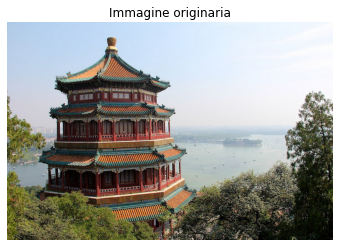

In [266]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Immagine originaria")
plt.show()

Possiamo serializzare l'immagine utilizzando la codifica JPEG mediante il metodo **encode_jpeg**

In [90]:
data = tf.io.encode_jpeg(img)

E definire un nuovo PB Example.

In [92]:
example_immagine = Example(features=Features(
    feature={
        "image": Feature(bytes_list=BytesList(value=[data.numpy()]))
    }
)
)

Che posso serializzare e scrivere in un TFRecord

In [93]:
with tf.io.TFRecordWriter("immagini.tfrecord") as f:
    f.write(example_immagine.SerializeToString())

In [104]:
with tf.io.TFRecordWriter("immagini_collection.tfrecord") as f:
    for img in load_sample_images()['images']:
        f.write(Example(features=
                        Features(feature={
                            "image": Feature(bytes_list=BytesList(value=[tf.io.encode_jpeg(img).numpy()]))
                        }
                                )
                       ).SerializeToString()
               )

Dalla collection definita in precedenza posso ripristinare le immagini nel seguente modo:

In [105]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }
list_image = [tf.io.decode_jpeg(tf.io.parse_single_example(example,
                                                           feature_description)['image'].values[0])
              for example in tf.data.TFRecordDataset(["immagini_collection.tfrecord"])
             ] 

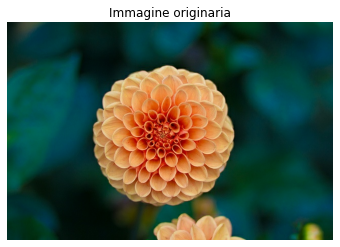

In [267]:
plt.imshow(list_image[1])
plt.axis("off")
plt.title("Immagine originaria")
plt.show()

Il PB Example non e' adatto a descrivere tipi di dati in cui si hanno sequenze di sequenze - list of lists -, ad esempio nel caso di classificazione di documenti testuali, dove un documento e' una sequenza di frasi ed ogni frase e' una sequena di parole. Per tali situazioni si utilizza il PB **SequenceExample**, la cui definizione e':
```
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```

In [107]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

Come per il PB Example, per SequenceExample abbiamo un metodo **parse_single_sequence_example** per ricostruire il PB SequenceExample serializzato. 

Nell'esempio inseriamo uno stralcio di un articolo di una testata giornalistica online in un TFRecord utilizzando il PB SequenceExample:

In [119]:
context = Features(feature={
    "author_name": Feature(bytes_list=BytesList(value=[b'Il Post'])),
    "title": Feature(bytes_list=BytesList(value=[word.encode('utf-8') for word in 'Il più grande mercato azionario d’Europa non è più Londra, ma Amsterdam'.split()])),
    "pub_date": Feature(int64_list=Int64List(value=[2021, 2, 12]))
})

document = """A gennaio Amsterdam è diventata il più grande centro di scambio di azioni d’Europa, aumentando di circa quattro volte il valore di quelle scambiate quotidianamente rispetto al 2020 e superando Londra, che per decenni è stata il più grande e importante mercato finanziario europeo.
Come ha raccontato il Financial Times, questo importante cambiamento è stato provocato da Brexit: a causa di un mancato accordo tra Regno Unito e Unione Europea, a partire da gennaio, quando si è verificata completamente l’uscita dall’Unione, sui mercati finanziari britannici non è più possibile comprare e vendere titoli denominati in euro: questo ha provocato un enorme spostamento di transazioni da un mercato finanziario a un altro."""

content_features = [Feature(bytes_list=BytesList(value=[word.encode('utf-8') for word in sentence.split()])) 
                    for sentence in document.split('\n')
                   ]

sequence_example = SequenceExample(
    context = context,
    feature_lists=FeatureLists(
        feature_list={
            "content": FeatureList(feature=content_features)
        }
    )
)

In [ ]:
sequence_example

In [121]:
sequence_example_serializzato = sequence_example.SerializeToString()

Applico il metodo di parsing o de-serializzazione del PB.

In [268]:
context_feature_descriptions = {
    "author_name": tf.io.VarLenFeature(tf.string),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
}

parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    sequence_example_serializzato,
    context_feature_descriptions,
    sequence_feature_descriptions)

In [132]:
print(tf.sparse.to_dense(
    parsed_feature_lists["content"]
)[0])
print(tf.sparse.to_dense(
    parsed_feature_lists["content"]
)[1])

tf.Tensor(
[b'A' b'gennaio' b'Amsterdam' b'\xc3\xa8' b'diventata' b'il' b'pi\xc3\xb9'
 b'grande' b'centro' b'di' b'scambio' b'di' b'azioni'
 b'd\xe2\x80\x99Europa,' b'aumentando' b'di' b'circa' b'quattro' b'volte'
 b'il' b'valore' b'di' b'quelle' b'scambiate' b'quotidianamente'
 b'rispetto' b'al' b'2020' b'e' b'superando' b'Londra,' b'che' b'per'
 b'decenni' b'\xc3\xa8' b'stata' b'il' b'pi\xc3\xb9' b'grande' b'e'
 b'importante' b'mercato' b'finanziario' b'europeo.' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''], shape=(67,), dtype=string)
tf.Tensor(
[b'Come' b'ha' b'raccontato' b'il' b'Financial' b'Times,' b'questo'
 b'importante' b'cambiamento' b'\xc3\xa8' b'stato' b'provocato' b'da'
 b'Brexit:' b'a' b'causa' b'di' b'un' b'mancato' b'accordo' b'tra'
 b'Regno' b'Unito' b'e' b'Unione' b'Europea,' b'a' b'partire' b'da'
 b'gennaio,' b'quando' b'si' b'\xc3\xa8' b'verificata' b'completamente'
 b'l\xe2\x80\x99uscita' b'dall\xe2\x80\x99Unione,' b

In [269]:
(X_train_full, y_train_full),(X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

## Preprocessing Layer in TF
Anche TF permette di pre-processare i dati in modo da trasformare ogni feature in feature numerica. Nello specifico vengono definiti una serie di preprocessing layer, alcuni dei quali sono 'addestrabili'.

Un primo approccio e' implementare il layer di preprocessing mediante un layer custom  estendendo la classe **Layer**.

In [134]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [169]:
standardization = Standardization(input_shape=[28, 28])

sample_images = X_train[:2,:,:]
sample_images.shape
standardization.adapt(sample_images)

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [170]:
history = model.fit(X_train, y_train,
          epochs=5,
          validation_data=(X_valid,y_valid)
         )

Epoch 1/5
1719/1719 [==============================] - 2s 1ms/step - loss: 58879.3711 - accuracy: 0.5687 - val_loss: 8006.7529 - val_accuracy: 0.4568
Epoch 2/5
1719/1719 [==============================] - 2s 1ms/step - loss: 4468.7935 - accuracy: 0.4131 - val_loss: 2184.0898 - val_accuracy: 0.3776
Epoch 3/5
1719/1719 [==============================] - 2s 1ms/step - loss: 617.9565 - accuracy: 0.2562 - val_loss: 406.9533 - val_accuracy: 0.2076
Epoch 4/5
1719/1719 [==============================] - 2s 1ms/step - loss: 135.1409 - accuracy: 0.1865 - val_loss: 154.5117 - val_accuracy: 0.1586
Epoch 5/5
1719/1719 [==============================] - 2s 1ms/step - loss: 65.9401 - accuracy: 0.1464 - val_loss: 395.2178 - val_accuracy: 0.1284


#### Feature categoriche

In [209]:
house = pd.read_csv('housing.csv')

In [210]:
y = house['median_house_value'].values
X = house.drop(['median_house_value','total_bedrooms'] , axis=1)

In [217]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   population          20640 non-null  float64
 5   households          20640 non-null  float64
 6   median_income       20640 non-null  float64
 7   ocean_proximity     20640 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.3+ MB


In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [229]:
X_train_num, X_train_cat = X_train[:,:-1].astype('float64'), X_train[:,-1]
X_test_num, X_test_cat = X_test[:,:-1].astype('float64'), X_test[:,-1]

In [233]:
X_train_num.dtype

dtype('float64')

Per la feature categorica  dobbiamo assegnare ad ogni categoria un indice

In [184]:
vocab = np.unique(X_train_cat)
indices = tf.range(len(vocab), dtype=tf.int64)

Definiamo un initializzatore per definire una tabella di lookup, passando il vocabolario e gli indici da associare agli elementi del vocabolario

In [185]:
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)

In [186]:
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

Per la creazione della tabella di lookup - agisce come un dict in Python - inseriamo dei bucket vuoti che verranno riempiti quando si cercano degli elementi non presenti nel vocabolario iniziale.

In [187]:
test_categories = tf.constant(['NEAR BAY','DESERT'])
cat_indices = table.lookup(test_categories)
print(cat_indices)
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

tf.Tensor([3 5], shape=(2,), dtype=int64)


<tf.Tensor: shape=(2, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)>

In [188]:
one_hot_layer = keras.layers.experimental.preprocessing.TextVectorization()

In [189]:
one_hot_layer.adapt(X_train_cat[:100])

In [190]:
one_hot_layer(X_train_cat)

<tf.Tensor: shape=(15480, 2), dtype=int64, numpy=
array([[4, 2],
       [4, 2],
       [4, 2],
       ...,
       [4, 2],
       [4, 2],
       [5, 6]], dtype=int64)>

Nel caso in cui le categorie per feature siano maggiori di 10 - indicativamente - e' possibile mappare ogni categoria in un spazio a bassa dimensionalita' - con dimensione minore del numero di categorie. Questo processo viene definito come **embedding** e consiste nell'assegnare ad ogni valore categorico un vettore di dimensioni ridotte.

In Keras possiamo definire un layer **EmbeddingMatrix** che rappresenta un mapping tra i valori della feature categorica e vettori nello spazio a bassa dimensionalita'. 

In [191]:
embedding_dim = 2
embedding = keras.layers.Embedding(input_dim = len(vocab) + num_oov_buckets, output_dim = embedding_dim)

In [192]:
embedding(cat_indices)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.03935261, -0.0372553 ],
       [ 0.02029271,  0.03611598]], dtype=float32)>

Dal momento che l'embedding e' adddestrabile possiamo imparare il mapping migliore modificando i pesi della matrice precedente.

In [245]:
standardization = Standardization()
sample_ = X_train_num[:100]
standardization.adapt(sample_)

num_input = keras.layers.Input(shape=X_train_num.shape[1:])
cat_input = keras.layers.Input([], dtype=tf.string)
standard_input = standardization(num_input)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(cat_input)
cat_embedding = keras.layers.Embedding(input_dim = len(vocab) + num_oov_buckets, output_dim=2, name = 'embedding')(cat_indices)
encoded_input = keras.layers.concatenate([standard_input, cat_embedding])
hidden1 = keras.layers.Dense(30, activation="relu")(encoded_input)
hidden2 = keras.layers.Dense(10, activation="relu")(hidden1)
output = keras.layers.Dense(1)(hidden2)
model = keras.models.Model(inputs=[num_input, cat_input], outputs=[output])

In [246]:
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )
history = model.fit((X_train_num,X_train_cat), y_train,
                    epochs=5
                   )
mse_test = model.evaluate((X_test_num, X_test_cat), y_test)
mse_test

Epoch 1/5
484/484 [==============================] - 0s 682us/step - loss: 33740408832.0000 0s - loss: 37773742080.00
Epoch 2/5
484/484 [==============================] - 0s 676us/step - loss: 16115621888.0000
Epoch 3/5
484/484 [==============================] - 0s 671us/step - loss: 13744280576.0000
Epoch 4/5
484/484 [==============================] - 0s 678us/step - loss: 13404760064.0000
Epoch 5/5
162/162 [==============================] - 0s 574us/step - loss: 13232875520.0000


13232875520.0